In [1]:
import pandas as pd
import plotly as py 
import plotly.graph_objs as go
import plotly.express as px
import kaleido
import os
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
import math as m
import time

from scipy import stats

from sklearn import datasets
from sklearn.model_selection import train_test_split , KFold
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from collections import Counter
# setup offline mode 
py.offline.init_notebook_mode(connected=True)

pd.set_option('display.max_rows', 20)

In [2]:
def word_to_vector(word: str) -> np.array:
    array = np.zeros(len(CZ_ALPHABET))
    lst = []
    for i, alph in enumerate(CZ_ALPHABET):
        array[i] = word.count(alph)
        lst.append(word.count(alph))
    return pd.Series(lst)

def word_to_vector_alph(word: str, alphabet: list) -> pd.Series:
    array = np.zeros(len(alphabet))
    lst = []
    for i, alph in enumerate(alphabet):
        lst.append(word.count(alph))
    return pd.Series(lst)

def get_str_substrings(string: str, low: int = 1, high: int = None) -> list:
    print(string)
    if high is None:
        high = len(string)
    substrings = []
    for i in range(0, len(string)):
        for k in range(0, len(string) - i):
            substring = string[k:i+k+1]
            if low <= len(substring) <= high: substrings.append(substring)
    return substrings

# Method 1: Alphabet vector

In [3]:
data = pd.read_csv('data.csv', encoding='ansi', usecols=['Obec', 'Okres', 'Kraj', 'Latitude', 'Longitude'])

In [4]:
data['Obec'] = data['Obec'].str.lower()

In [5]:
CZ_ALPHABET = ['a', 'á', 'b', 'c', 'č', 'd', 'ď',
               'e', 'é', 'ě', 'f', 'g', 'h', 'ch', 
               'i', 'í', 'j', 'k', 'l', 'm', 'n', 
               'ň', 'o', 'ó', 'p', 'q', 'r', 'ř',
               's', 'š', 't', 'ť', 'u', 'ú','ů', 
               'v', 'w', 'x', 'y', 'ý','z', 'ž', ' ']

#abcčdďeéfghiíjklmnňopqrřsštťuúůvwxyýzž

In [6]:
data = pd.read_csv('data.csv', encoding='ansi', usecols=['Obec', 'Okres', 'Kraj', 'Latitude', 'Longitude'])

data[CZ_ALPHABET] = data['Obec'].apply(word_to_vector)

In [7]:
# define x and y
x = data[CZ_ALPHABET]
y = data['Kraj']

x_train, x_test, y_train, y_test= train_test_split(x, y,
                                                   test_size = 0.2,
                                                   shuffle = True, #shuffle the data to avoid bias
                                                   random_state = 0)

In [8]:
K = 5

scaler = Normalizer().fit(x_train) # the scaler is fitted to the training set
normalized_x_train = scaler.transform(x_train) # the scaler is applied to the training set
normalized_x_test = scaler.transform(x_test) # the scaler is applied to the test set

knn = KNeighborsClassifier(K)
knn.fit(normalized_x_train, y_train)
y_pred_sklearn = knn.predict(normalized_x_test)
y_pred_sklearn = pd.Series(y_pred_sklearn)

#TFIDF
accuracy_score(y_test, y_pred_sklearn)

0.12939297124600638

# Method 2: Linguistic parameters 

In [9]:
data['Délka'] = data['Obec'].apply(len)

# Method 3: Automatic linguistic parameters

In [14]:
def tfidf(len_doc_occ: int, len_doc: int, N: int, D: int) -> float:
    tf =  len_doc_occ / len_doc
    idf = N / D
    return tf * idf
#

data = pd.read_csv('data.csv', encoding = 'ansi', usecols=['Obec', 'Kraj'])
data['Obec'] = data['Obec'].str.lower()
data['substring'] = data['Obec'].apply(lambda string: get_str_substrings(string=string, low=2, high=4))

corpus = data[['substring', 'Kraj']].explode(column='substring')
grouping = corpus.groupby(corpus['substring'])

df_doc_sizes = corpus.groupby(corpus['Kraj']).apply(lambda x: x['substring'].shape[0])

st = time.time()
print('Calculating total frequency of substrings.')
df_substring_stats = grouping.apply(len).reset_index().rename(columns={0 : 'freq'})
df_substring_stats['freq'] = pd.to_numeric(df_substring_stats['freq'])

print('Calculating the number of regions in which the substring occurs.')
df_substring_stats['n_krajů'] = pd.to_numeric(grouping.apply(lambda x: len(x['Kraj'].unique())).reset_index(drop=True))

print('Writing out the regions.')
df_substring_stats['kraje'] = grouping.apply(lambda x: x['Kraj'].tolist()).reset_index(drop=True)

print('Calculating mode and count of the regions (for max tfidf).')
df_substring_stats[['kraj_max', 'kraj_max_count']] = df_substring_stats['kraje'].apply(lambda x:
                                                                                       list(np.concatenate(stats.mode(x)))
                                                                                       ).tolist()

df_substring_stats['kraj_max_count'] = pd.to_numeric(df_substring_stats['kraj_max_count'])

print('Calculating the size of the mode region documents.')
df_substring_stats['kraj_size'] = pd.to_numeric(df_substring_stats['kraj_max'].apply(lambda x: df_doc_sizes[x]))

print('Calculating maximum tf.')
df_substring_stats['tf'] = df_substring_stats['kraj_max_count'] / df_substring_stats['kraj_size']

print('Calculating idf')
df_substring_stats['idf'] = np.log2(14 / df_substring_stats['n_krajů'])

print('Calculating max tfidf')
df_substring_stats['max_tfidf'] = df_substring_stats['tf'] * df_substring_stats['idf']

print(f'Done in {time.time() - st:.2f} seconds')
print('Saving to csv.')
df_substring_stats.to_csv('substring_stats.csv')

print('Done saving.')
df_substring_stats

abertamy
adamov
adamov
adamov
adršpach
albrechtice
albrechtice
albrechtice nad orlicí
albrechtice nad vltavou
albrechtice v jizerských horách
albrechtičky
alojzov
andělská hora
andělská hora
anenská studánka
archlebov
arneštovice
arnolec
arnoltice
aš
babice
babice
babice
babice
babice
babice
babice nad svitavou
babice u rosic
babylon
bácovice
bačalky
bačetín
bačice
bačkov
bačkovice
bakov nad jizerou
baliny
balkova lhota
banín
bánov
báňovice
bantice
barchov
barchov
barchovice
bartošovice
bartošovice v orlických horách
bartoušov
bařice-velké těšany
baška
bašnice
bašť
batelov
batňovice
bavorov
bavory
bavoryně
bdeněves
bdín
bečice
bečice
bečov
bečov nad teplou
bečváry
bedihošť
bednárec
bednáreček
bedřichov
bedřichov
běhařov
běhařovice
běchary
bechlín
bechyně
bělá
bělá
bělá
bělá
bělá nad radbuzou
bělá nad svitavou
bělá pod bezdězem
bělá pod pradědem
bělá u jevíčka
bělčice
běleč
běleč
běleč
běleč nad orlicí
bělkovice-lašťany
běloky
bělotín
bělov
bělušice
bělušice
benátky
benátky
benátky nad 

,substring,freq,n_krajů,kraje,kraj_max,kraj_max_count,kraj_size,tf,idf,max_tfidf
0,(,5,5,"[Jihočeský kraj, Středočeský kraj, Jihomoravsk...",Jihomoravský kraj,1,14154,0.000071,1.485427,0.000105
1,(v,5,5,"[Jihočeský kraj, Středočeský kraj, Jihomoravsk...",Jihomoravský kraj,1,14154,0.000071,1.485427,0.000105
2,(vo,5,5,"[Jihočeský kraj, Středočeský kraj, Jihomoravsk...",Jihomoravský kraj,1,14154,0.000071,1.485427,0.000105
3,-,1,1,[Středočeský kraj],Středočeský kraj,1,21735,0.000046,3.807355,0.000175
4,-,1,1,[Středočeský kraj],Středočeský kraj,1,21735,0.000046,3.807355,0.000175
...,...,...,...,...,...,...,...,...,...,...
16668,žďá,15,6,"[Jihočeský kraj, Jihočeský kraj, Kraj Vysočina...",Jihočeský kraj,4,12522,0.000319,1.222392,0.000390
16669,žďár,15,6,"[Jihočeský kraj, Jihočeský kraj, Kraj Vysočina...",Jihočeský kraj,4,12522,0.000319,1.222392,0.000390
16670,žů,1,1,[Jihomoravský kraj],Jihomoravský kraj,1,14154,0.000071,3.807355,0.000269
16671,žův,1,1,[Jihomoravský kraj],Jihomoravský kraj,1,14154,0.000071,3.807355,0.000269


In [15]:
df_substring_stats.sort_values(by='max_tfidf', ascending=False)#[['substring', 'max_tfidf']]

,substring,freq,n_krajů,kraje,kraj_max,kraj_max_count,kraj_size,tf,idf,max_tfidf
9631,prah,2,2,"[Středočeský kraj, Hlavní město Praha]",Hlavní město Praha,1,9,0.111111,2.807355,0.311928
7725,niso,8,1,"[Liberecký kraj, Liberecký kraj, Liberecký kra...",Liberecký kraj,8,5427,0.001474,3.807355,0.005612
5165,isou,8,1,"[Liberecký kraj, Liberecký kraj, Liberecký kra...",Liberecký kraj,8,5427,0.001474,3.807355,0.005612
2613,d ni,8,1,"[Liberecký kraj, Liberecký kraj, Liberecký kra...",Liberecký kraj,8,5427,0.001474,3.807355,0.005612
7724,nis,8,1,"[Liberecký kraj, Liberecký kraj, Liberecký kra...",Liberecký kraj,8,5427,0.001474,3.807355,0.005612
...,...,...,...,...,...,...,...,...,...,...
11135,strá,24,13,"[Kraj Vysočina, Liberecký kraj, Moravskoslezsk...",Jihočeský kraj,3,12522,0.000240,0.106915,0.000026
9628,pra,25,13,"[Olomoucký kraj, Středočeský kraj, Jihomoravsk...",Jihomoravský kraj,3,14154,0.000212,0.106915,0.000023
9819,ra,574,14,"[Karlovarský kraj, Moravskoslezský kraj, Plzeň...",Středočeský kraj,103,21735,0.004739,0.000000,0.000000
9627,pr,75,14,"[Olomoucký kraj, Olomoucký kraj, Středočeský k...",Jihomoravský kraj,11,14154,0.000777,0.000000,0.000000


In [16]:
# find 99th percentile
PERCENTILE = np.quantile(df_substring_stats['max_tfidf'], q=0.99)
ALPHABET = df_substring_stats[df_substring_stats['max_tfidf'] > PERCENTILE]['substring'].tolist()
print(ALPHABET)
print('Vector length: ', len(ALPHABET))

[' beč', ' brn', ' han', ' j', ' ji', ' jiz', ' jič', ' luž', ' lá', ' láz', ' met', ' ni', ' nis', ' od', ' odr', ' oh', ' ohř', ' or', ' orl', ' osl', ' pec', ' ral', ' v o', ' vl', ' vlt', ' úd', ' údo', ' úp', ' živ', 'a ha', 'ad j', 'ad n', 'ala', 'alaš', 'als', 'alsk', 'ané', 'ašs', 'ašsk', 'bečv', 'blon', 'brna', 'ce', 'ckýc', 'd be', 'd j', 'd ji', 'd me', 'd n', 'd ni', 'd od', 'd oh', 'd or', 'd os', 'eda', 'elko', 'erou', 'etu', 'etuj', 'ezs', 'ezsk', 'ečv', 'ečva', 'ečvo', 'eště', 'hané', 'ic', 'ice', 'iso', 'isou', 'ivot', 'ize', 'izer', 'ješ', 'ješt', 'jiz', 'jize', 'jič', 'jičí', 'ká h', 'laš', 'lašs', 'lezs', 'licí', 'lkou', 'lske', 'lta', 'ltav', 'metu', 'na h', 'neda', 'nis', 'niso', 'odro', 'ohř', 'ohří', 'opav', 'orl', 'orli', 'ov', 'prah', 'přel', 'rals', 'rli', 'rlic', 'rásn', 'semi', 'ske', 'skem', 'slez', 'sné ', 'sou', 'tep', 'tepl', 'tuj', 'tují', 'těd', 'ují', 'užni', 'v o', 'v or', 'vala', 'vicí', 'vlt', 'vlta', 'zdob', 'zer', 'zero', 'zák', 'áří', 'é he', '

C:\Users\simib\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3641: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



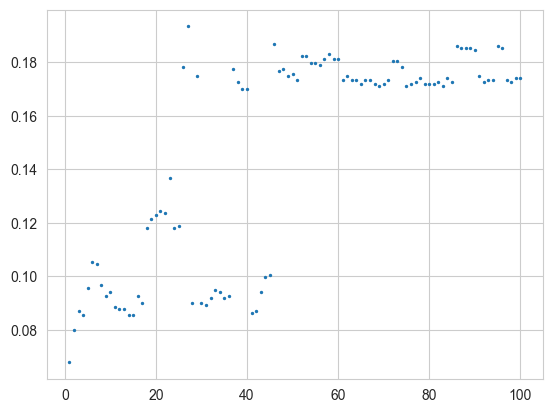

0.19329073482428116


In [17]:
data[ALPHABET] = data['Obec'].apply(lambda x: word_to_vector_alph(word=x, alphabet=ALPHABET))
data

x = data[ALPHABET]
y = data['Kraj']

x_train, x_test, y_train, y_test= train_test_split(x, y,
                                                   test_size = 0.2,
                                                   shuffle = True, #shuffle the data to avoid bias
                                                   random_state = 0)
K = 50

accuracies = []
for K in range(1, 101):
    scaler = Normalizer().fit(x_train) # the scaler is fitted to the training set
    normalized_x_train = scaler.transform(x_train) # the scaler is applied to the training set
    normalized_x_test = scaler.transform(x_test) # the scaler is applied to the test set

    knn = KNeighborsClassifier(K)
    knn.fit(normalized_x_train, y_train)
    y_pred_sklearn = knn.predict(normalized_x_test)
    y_pred_sklearn = pd.Series(y_pred_sklearn)

    #TFIDF
    accuracies.append(accuracy_score(y_test, y_pred_sklearn))



plt.scatter(np.linspace(1, 100, 100), accuracies, s=2)
plt.show()
print(max(accuracies))

In [177]:
def get_substring_stats(data: pd.DataFrame, low: int=1, high: int = None) -> pd.DataFrame:
    print('Getting substring stats using the following parameters:')
    print(f'Substring length interval: [{low}, {high}]')
    st = time.time()

    data.loc['Obec'] = data['Obec'].str.lower()
    print(data['Obec'])
    data['substring'] = data['Obec'].apply(lambda string: get_str_substrings(string=string, low=low, high=high))

    corpus = data[['substring', 'Kraj']].explode(column='substring')
    grouping = corpus.groupby(corpus['substring'])

    df_doc_sizes = corpus.groupby(corpus['Kraj']).apply(lambda x: x['substring'].shape[0])

    print('Calculating total frequency of substrings.')
    df_substring_stats = grouping.apply(len).reset_index().rename(columns={0 : 'freq'})
    df_substring_stats['freq'] = pd.to_numeric(df_substring_stats['freq'])

    print('Calculating the number of regions in which the substring occurs.')
    df_substring_stats['n_krajů'] = pd.to_numeric(grouping.apply(lambda x: len(x['Kraj'].unique())).reset_index(drop=True))

    print('Writing out the regions.')
    df_substring_stats['kraje'] = grouping.apply(lambda x: x['Kraj'].tolist()).reset_index(drop=True)

    print('Calculating mode and count of the regions (for max tfidf).')
    df_substring_stats[['kraj_max', 'kraj_max_count']] = df_substring_stats['kraje'].apply(lambda x:
                                                                                           list(np.concatenate(stats.mode(x)))
                                                                                           ).tolist()

    df_substring_stats['kraj_max_count'] = pd.to_numeric(df_substring_stats['kraj_max_count'])

    print('Calculating the size of the mode region documents.')
    df_substring_stats['kraj_size'] = pd.to_numeric(df_substring_stats['kraj_max'].apply(lambda x: df_doc_sizes[x]))

    print('Calculating maximum tf.')
    df_substring_stats['tf'] = df_substring_stats['kraj_max_count'] / df_substring_stats['kraj_size']

    print('Calculating idf')
    df_substring_stats['idf'] = np.log2(14 / df_substring_stats['n_krajů'])

    print('Calculating max tfidf')
    df_substring_stats['max_tfidf'] = df_substring_stats['tf'] * df_substring_stats['idf']

    print('Saving to csv.')
    df_substring_stats.to_csv('substring_stats.csv')

    print('Saving finished.')
    print(f'Done in {time.time() - st:.2f} seconds')
    return df_substring_stats


def process_data(data: pd.DataFrame,low: int = 1, high: int = None, q: float = 0.99,
                   vec_len: int = None, pca: bool = False, pca_dim: int = 5):
    print('Calculating data with using following parameters:')
    print(f'Substring length interval: [{low}, {high}]')


data = pd.read_csv('data.csv', encoding = 'ansi', usecols=['Obec', 'Kraj'])

get_substring_stats(data, low=2, high=3)

Getting substring stats using the following parameters:
Substring length interval: [2, 3]
0         Abertamy
1           Adamov
2           Adamov
3           Adamov
4         Adršpach
           ...    
6255        Žulová
6256       Žumberk
6257    Županovice
6258    Županovice
Obec           NaN
Name: Obec, Length: 6260, dtype: object
Abertamy
Adamov
Adamov
Adamov
Adršpach
Albrechtice
Albrechtice
Albrechtice nad Orlicí
Albrechtice nad Vltavou
Albrechtice v Jizerských horách
Albrechtičky
Alojzov
Andělská Hora
Andělská Hora
Anenská Studánka
Archlebov
Arneštovice
Arnolec
Arnoltice
Aš
Babice
Babice
Babice
Babice
Babice
Babice
Babice nad Svitavou
Babice u Rosic
Babylon
Bácovice
Bačalky
Bačetín
Bačice
Bačkov
Bačkovice
Bakov nad Jizerou
Baliny
Balkova Lhota
Banín
Bánov
Báňovice
Bantice
Barchov
Barchov
Barchovice
Bartošovice
Bartošovice v Orlických horách
Bartoušov
Bařice-Velké Těšany
Baška
Bašnice
Bašť
Batelov
Batňovice
Bavorov
Bavory
Bavoryně
Bdeněves
Bdín
Bečice
Bečice
Bečov
Bečov nad Tep

TypeError: object of type 'float' has no len()

In [14]:
px.scatter(data, x='Longitude', y='Latitude', color='Délka')

px.bar(data.groupby(data['Kraj'])['Délka'].apply(np.mean))

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['Obec', 'Kraj', 'substring', ' beč', ' bečv', ' bečva', ' bečvo', ' brn', ' brna', ' březn', ' han', ' hané', ' ji', ' jiz', ' jize', ' jizer', ' jič', ' jičí', ' jičín', ' luž', ' lužn', ' lužni', ' lá', ' láz', ' lázn', ' lázně', ' met', ' metu', ' metuj', ' na h', ' na ha', ' nad j', ' nad n', ' ni', ' nis', ' niso', ' nisou', ' od', ' odr', ' odro', ' odrou', ' oh', ' ohř', ' ohří', ' or', ' orl', ' orli', ' orlic', ' osl', ' osla', ' oslav', ' pec', ' ral', ' rals', ' ralsk', ' sedlo', ' u brn', ' v o', ' v or', ' v orl', ' vl', ' vlt', ' vlta', ' vltav', ' úd', ' údo', ' údol', ' údolí', ' živ', ' živo', ' život', 'a ha', 'a han', 'a hané', 'ablon', 'ad be', 'ad beč', 'ad j', 'ad ji', 'ad jiz', 'ad luž', 'ad me', 'ad met', 'ad n', 'ad ni', 'ad nis', 'ad od', 'ad odr', 'ad oh', 'ad ohř', 'ad or', 'ad orl', 'ad os', 'ad osl', 'ad vlt', 'ala', 'alaš', 'alašs', 'alašsk', 'als', 'alsk', 'alske', 'alskem', 'ané', 'avicí', 'ašs', 'ašsk', 'ašská', 'ašská ', 'ašské', 'ašské ', 'bečv', 'bečva', 'bečvo', 'bečvou', 'blon', 'brna', 'březno', 'ckýc', 'ckých', 'ckých ', 'd be', 'd beč', 'd bečv', 'd j', 'd ji', 'd jiz', 'd jize', 'd luž', 'd lužn', 'd me', 'd met', 'd metu', 'd n', 'd ni', 'd nis', 'd niso', 'd od', 'd odr', 'd odro', 'd oh', 'd ohř', 'd ohří', 'd or', 'd orl', 'd orli', 'd os', 'd osl', 'd osla', 'd ral', 'd rals', 'd vlt', 'd vlta', 'eda', 'elkou', 'elouč', 'erou', 'etu', 'etuj', 'etují', 'ezs', 'ezsk', 'ečv', 'ečva', 'ečvo', 'ečvou', 'eště', 'eštěd', 'hané', 'ice', 'ickýc', 'ických', 'iso', 'isou', 'ivot', 'ivoti', 'ivotic', 'ize', 'izer', 'izero', 'izerou', 'jablon', 'ješ', 'ješt', 'ještě', 'ještěd', 'jiz', 'jize', 'jizer', 'jizero', 'jič', 'jičí', 'jičín', 'kolov', 'krásn', 'ká h', 'lavou', 'laš', 'lašs', 'lašsk', 'lašská', 'lašské', 'lezs', 'lezsk', 'lický', 'lickýc', 'licí', 'lkou', 'lske', 'lskem', 'lta', 'ltav', 'ltavo', 'ltavou', 'lužni', 'lužnic', 'metu', 'metuj', 'metují', 'moravi', 'na h', 'na ha', 'na han', 'nad be', 'nad j', 'nad ji', 'nad me', 'nad n', 'nad ni', 'nad od', 'nad oh', 'nad or', 'nad os', 'neda', 'nis', 'niso', 'nisou', 'ní beč', 'od ral', 'odro', 'odrou', 'ohř', 'ohří', 'opav', 'oravi', 'oravic', 'orl', 'orli', 'orlic', 'orlick', 'orlicí', 'oslavo', 'ostrav', 'ovské', 'ovské ', 'prah', 'praha', 'prostě', 'přelo', 'přelou', 'rals', 'ralsk', 'ralske', 'ravicí', 'rli', 'rlic', 'rlický', 'rlicí', 'rostěj', 'rásn', 'semil', 'ske', 'skem', 'slavou', 'slez', 'slezs', 'slezsk', 'sné ', 'sou', 'strav', 'tep', 'tepl', 'tuj', 'tují', 'těd', 'u brn', 'u brna', 'ují', 'užni', 'užnic', 'užnicí', 'v o', 'v or', 'v orl', 'v orli', 'vala', 'valaš', 'valašs', 'vicí', 'vlt', 'vlta', 'vltav', 'vltavo', 'zer', 'zero', 'zerou', 'áří', 'é břez', 'é he', 'é ú', 'é úd', 'é údo', 'é údol', 'í beč', 'í bečv', 'údo', 'údol', 'údolí', 'ý l', 'čva', 'čvo', 'čvou', 'řelou', 'řelouč', 'řezno', 'šsk', 'šská', 'šská ', 'šské', 'šské ', 'štěd', 'živo', 'život', 'životi', 'žnicí'] but received: Longitude

In [ ]:
px.scatter(data[data['Obec'].str.contains('anov')], x='Longitude', y='Latitude', custom_data=['Obec'])